In [2]:
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop
from nltk import FreqDist
import numpy as np
import os
import datetime
from __future__ import print_function

Using TensorFlow backend.


In [3]:
def create_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(X_vocab_len, 2000, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model

In [4]:
def process_data(word_sentences, max_len, word_to_ix):
    # Vectorizing each element in each sequence
    sequences = np.zeros((len(word_sentences), max_len, len(word_to_ix)))
    for i, sentence in enumerate(word_sentences):
        for j, word in enumerate(sentence):
            sequences[i, j, word] = 1.
    return sequences

In [5]:
MAX_LEN = 200
VOCAB_SIZE = 20000
BATCH_SIZE = 100
LAYER_NUM = 1
HIDDEN_DIM = 100
NB_EPOCH = 20

In [6]:
def load_data(source, dist, max_len, vocab_size):

    # Reading raw text from source and destination files
    f = open(source, 'r')
    X_data = f.read()
    f.close()
    f = open(dist, 'r')
    y_data = f.read()
    f.close()
    
    #Reduce number of inputs
    print(len(X_data))
    print(len(y_data))
    #X_data = X_data[0:50000]
    #y_data = y_data[0:50000]
    #print(len(X_data))
    #print(len(y_data))
    
    # Splitting raw text into array of sequences
    X = [text_to_word_sequence(x)[::-1] for x, y in zip(X_data.split('\n'), y_data.split('\n')) if len(x) > 0 and len(y) > 0 and len(x) <= max_len and len(y) <= max_len]
    y = [text_to_word_sequence(y) for x, y in zip(X_data.split('\n'), y_data.split('\n')) if len(x) > 0 and len(y) > 0 and len(x) <= max_len and len(y) <= max_len]

    print(len(X))
    print(len(y))
    X = X[0:50000]
    y = y[0:50000]
    print(len(X))
    print(len(y))
    
    # Creating the vocabulary set with the most common words
    dist = FreqDist(np.hstack(X))
    X_vocab = dist.most_common(vocab_size-1)
    dist = FreqDist(np.hstack(y))
    y_vocab = dist.most_common(vocab_size-1)

    # Creating an array of words from the vocabulary set, we will use this array as index-to-word dictionary
    X_ix_to_word = [word[0] for word in X_vocab]
    # Adding the word "ZERO" to the beginning of the array
    X_ix_to_word.insert(0, 'ZERO')
    # Adding the word 'UNK' to the end of the array (stands for UNKNOWN words)
    X_ix_to_word.append('UNK')

    # Creating the word-to-index dictionary from the array created above
    X_word_to_ix = {word:ix for ix, word in enumerate(X_ix_to_word)}

    # Converting each word to its index value
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word_to_ix:
                X[i][j] = X_word_to_ix[word]
            else:
                X[i][j] = X_word_to_ix['UNK']

    y_ix_to_word = [word[0] for word in y_vocab]
    y_ix_to_word.insert(0, 'ZERO')
    y_ix_to_word.append('UNK')
    y_word_to_ix = {word:ix for ix, word in enumerate(y_ix_to_word)}
    for i, sentence in enumerate(y):
        for j, word in enumerate(sentence):
            if word in y_word_to_ix:
                y[i][j] = y_word_to_ix[word]
            else:
                y[i][j] = y_word_to_ix['UNK']
    return (X, len(X_vocab)+2, X_word_to_ix, X_ix_to_word, y, len(y_vocab)+2, y_word_to_ix, y_ix_to_word)

In [7]:
X, X_vocab_len, X_word_to_ix, X_ix_to_word, y, y_vocab_len, y_word_to_ix, y_ix_to_word = load_data('data/train_article.txt', 'data/train_title.txt', MAX_LEN, VOCAB_SIZE)

4252601
2244671
50000
50000
50000
50000


In [13]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import sys

In [8]:
X_max_len = max([len(sentence) for sentence in X])
y_max_len = max([len(sentence) for sentence in y])
X = pad_sequences(X, maxlen=X_max_len, dtype='int32')
y = pad_sequences(y, maxlen=y_max_len, dtype='int32')
model = create_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, HIDDEN_DIM, LAYER_NUM)

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 2000)          40002000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               840400    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 29, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 29, 100)           80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 29, 20001)         2020101   
_________________________________________________________________
activation_1 (Activation)    (None, 29, 20001)         0         
Total params: 42,942,901
Trainable params: 42,942,901
Non-trainable params: 0
________________________________________________________________

In [ ]:
for k in range(0, NB_EPOCH+1):
            # Shuffling the training data every epoch to avoid local minima
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Training 2000 sequences at a time
            for i in range(0, len(X), 2000):
                if i + 2000 >= len(X):
                    i_end = len(X)
                else:
                    i_end = i + 2000
                y_sequences = process_data(y[i:i_end], y_max_len, y_word_to_ix)

                print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
                model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=1, verbose=1, validation_split=0.2)

[INFO] Training model: epoch 0th 0/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 28s 17ms/step - loss: 3.9301 - acc: 0.6693 - val_loss: 2.9478 - val_acc: 0.7105
[INFO] Training model: epoch 0th 2000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 2.9038 - acc: 0.7153 - val_loss: 2.9199 - val_acc: 0.7122
[INFO] Training model: epoch 0th 4000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 17ms/step - loss: 2.9300 - acc: 0.7108 - val_loss: 2.9202 - val_acc: 0.7135
[INFO] Training model: epoch 0th 6000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 2.9191 - acc: 0.7118 - val_loss: 2.8063 - val_acc: 0.7155
[INFO] Training model: epoch 0th 8000/50000 samples
Train on 1600 s

[INFO] Training model: epoch 1th 20000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 17ms/step - loss: 2.2653 - acc: 0.7216 - val_loss: 2.2347 - val_acc: 0.7248
[INFO] Training model: epoch 1th 22000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 2.2550 - acc: 0.7216 - val_loss: 2.2387 - val_acc: 0.7246
[INFO] Training model: epoch 1th 24000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 2.3222 - acc: 0.7153 - val_loss: 2.2086 - val_acc: 0.7238
[INFO] Training model: epoch 1th 26000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 2.2043 - acc: 0.7255 - val_loss: 2.2350 - val_acc: 0.7197
[INFO] Training model: epoch 1th 28000/50000 samples
Train o

[INFO] Training model: epoch 2th 40000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 17ms/step - loss: 2.0537 - acc: 0.7258 - val_loss: 2.0132 - val_acc: 0.7290
[INFO] Training model: epoch 2th 42000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 17ms/step - loss: 2.0062 - acc: 0.7292 - val_loss: 1.9985 - val_acc: 0.7304
[INFO] Training model: epoch 2th 44000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 17ms/step - loss: 1.9937 - acc: 0.7322 - val_loss: 1.9940 - val_acc: 0.7281
[INFO] Training model: epoch 2th 46000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 2.0279 - acc: 0.7288 - val_loss: 1.9932 - val_acc: 0.7334
[INFO] Training model: epoch 2th 48000/50000 samples
Train o

1600/1600 [==============================] - 26s 17ms/step - loss: 1.7187 - acc: 0.7385 - val_loss: 1.6845 - val_acc: 0.7402
[INFO] Training model: epoch 5th 10000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.6935 - acc: 0.7411 - val_loss: 1.7480 - val_acc: 0.7317
[INFO] Training model: epoch 5th 12000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.7202 - acc: 0.7374 - val_loss: 1.6902 - val_acc: 0.7434
[INFO] Training model: epoch 5th 14000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.7103 - acc: 0.7397 - val_loss: 1.7347 - val_acc: 0.7392
[INFO] Training model: epoch 5th 16000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step -

1600/1600 [==============================] - 26s 17ms/step - loss: 1.6199 - acc: 0.7445 - val_loss: 1.6610 - val_acc: 0.7364
[INFO] Training model: epoch 6th 30000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.6418 - acc: 0.7417 - val_loss: 1.6970 - val_acc: 0.7401
[INFO] Training model: epoch 6th 32000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.6168 - acc: 0.7437 - val_loss: 1.6180 - val_acc: 0.7469
[INFO] Training model: epoch 6th 34000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.6566 - acc: 0.7432 - val_loss: 1.6620 - val_acc: 0.7433
[INFO] Training model: epoch 6th 36000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step -

1600/1600 [==============================] - 26s 16ms/step - loss: 1.5605 - acc: 0.7465 - val_loss: 1.5828 - val_acc: 0.7426
[INFO] Training model: epoch 8th 0/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.4485 - acc: 0.7554 - val_loss: 1.4440 - val_acc: 0.7528
[INFO] Training model: epoch 8th 2000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.4377 - acc: 0.7558 - val_loss: 1.4172 - val_acc: 0.7583
[INFO] Training model: epoch 8th 4000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.4219 - acc: 0.7553 - val_loss: 1.4377 - val_acc: 0.7556
[INFO] Training model: epoch 8th 6000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 

1600/1600 [==============================] - 26s 16ms/step - loss: 1.3844 - acc: 0.7621 - val_loss: 1.3824 - val_acc: 0.7571
[INFO] Training model: epoch 9th 20000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.3825 - acc: 0.7625 - val_loss: 1.4307 - val_acc: 0.7530
[INFO] Training model: epoch 9th 22000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.3984 - acc: 0.7604 - val_loss: 1.3985 - val_acc: 0.7605
[INFO] Training model: epoch 9th 24000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step - loss: 1.3863 - acc: 0.7627 - val_loss: 1.3599 - val_acc: 0.7644
[INFO] Training model: epoch 9th 26000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/step -

1600/1600 [==============================] - 27s 17ms/step - loss: 1.3205 - acc: 0.7679 - val_loss: 1.3231 - val_acc: 0.7679
[INFO] Training model: epoch 10th 40000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.3430 - acc: 0.7646 - val_loss: 1.3657 - val_acc: 0.7657
[INFO] Training model: epoch 10th 42000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.3595 - acc: 0.7633 - val_loss: 1.3748 - val_acc: 0.7612
[INFO] Training model: epoch 10th 44000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.3303 - acc: 0.7646 - val_loss: 1.3436 - val_acc: 0.7615
[INFO] Training model: epoch 10th 46000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 26s 16ms/st

1600/1600 [==============================] - 27s 17ms/step - loss: 1.1498 - acc: 0.7858 - val_loss: 1.1441 - val_acc: 0.7862
[INFO] Training model: epoch 12th 20000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.1253 - acc: 0.7867 - val_loss: 1.1299 - val_acc: 0.7872
[INFO] Training model: epoch 12th 22000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.1604 - acc: 0.7849 - val_loss: 1.1918 - val_acc: 0.7796
[INFO] Training model: epoch 12th 24000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 1.1476 - acc: 0.7858 - val_loss: 1.1463 - val_acc: 0.7855
[INFO] Training model: epoch 12th 26000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/st

1600/1600 [==============================] - 27s 17ms/step - loss: 0.9100 - acc: 0.8159 - val_loss: 0.8761 - val_acc: 0.8252
[INFO] Training model: epoch 15th 16000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.9580 - acc: 0.8119 - val_loss: 0.9182 - val_acc: 0.8182
[INFO] Training model: epoch 15th 18000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.9296 - acc: 0.8155 - val_loss: 0.9065 - val_acc: 0.8214
[INFO] Training model: epoch 15th 20000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.9363 - acc: 0.8118 - val_loss: 0.9553 - val_acc: 0.8099
[INFO] Training model: epoch 15th 22000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/st

1600/1600 [==============================] - 27s 17ms/step - loss: 0.8999 - acc: 0.8194 - val_loss: 0.8995 - val_acc: 0.8173
[INFO] Training model: epoch 16th 36000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.9377 - acc: 0.8146 - val_loss: 0.8727 - val_acc: 0.8198
[INFO] Training model: epoch 16th 38000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.9069 - acc: 0.8176 - val_loss: 0.9190 - val_acc: 0.8162
[INFO] Training model: epoch 16th 40000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.9038 - acc: 0.8187 - val_loss: 0.9260 - val_acc: 0.8153
[INFO] Training model: epoch 16th 42000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/st

1600/1600 [==============================] - 27s 17ms/step - loss: 0.7422 - acc: 0.8407 - val_loss: 0.7688 - val_acc: 0.8382
[INFO] Training model: epoch 18th 14000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.7683 - acc: 0.8379 - val_loss: 0.7297 - val_acc: 0.8484
[INFO] Training model: epoch 18th 16000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.7400 - acc: 0.8413 - val_loss: 0.7298 - val_acc: 0.8447
[INFO] Training model: epoch 18th 18000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.7570 - acc: 0.8414 - val_loss: 0.7564 - val_acc: 0.8421
[INFO] Training model: epoch 18th 20000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/st

1600/1600 [==============================] - 27s 17ms/step - loss: 0.7564 - acc: 0.8403 - val_loss: 0.7213 - val_acc: 0.8480
[INFO] Training model: epoch 19th 34000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.7564 - acc: 0.8416 - val_loss: 0.7371 - val_acc: 0.8434
[INFO] Training model: epoch 19th 36000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.7635 - acc: 0.8422 - val_loss: 0.7374 - val_acc: 0.8444
[INFO] Training model: epoch 19th 38000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/step - loss: 0.7755 - acc: 0.8404 - val_loss: 0.7561 - val_acc: 0.8430
[INFO] Training model: epoch 19th 40000/50000 samples
Train on 1600 samples, validate on 400 samples
Epoch 1/1
1600/1600 [==============================] - 27s 17ms/st

In [ ]:
def load_test_data(source, preds, X_word_to_ix, max_len):
    f = open(source, 'r')
    X_data = f.read()
    f.close()
    

    f = open(preds, 'r')
    y_data = f.read()
    f.close()
    split_y_data = y_data.split('\n')
    X = [text_to_word_sequence(x)[::-1] for x in X_data.split('\n') if len(x) > 0 and len(x) <= max_len]
    y = [split_y_data[i] for i,x in enumerate(X_data.split('\n')) if len(x) > 0 and len(x) <= max_len]
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word_to_ix:
                X[i][j] = X_word_to_ix[word]
            else:
                X[i][j] = X_word_to_ix['UNK']
    return X,y, X_data.split('\n'), split_y_data

In [20]:
X_test, y_test, X_orig, y_orig = load_test_data('input/test.article.txt', 'input/test.title.txt', X_word_to_ix, MAX_LEN)

In [25]:
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32')

In [26]:
predictions = np.argmax(model.predict(X_test[0:7000]), axis=2)

In [28]:
sequences = []
for prediction in predictions:
    valids = [y_ix_to_word[index] for index in prediction if index > 0]
    sequence = ' '.join(valids)
    sequences.append(sequence)

In [34]:
from rouge import Rouge

In [35]:
def get_rouge_score(summarized, gold):
        rouge = Rouge()
        scores = rouge.get_scores(summarized, gold, avg=True)
        return scores

In [93]:
get_rouge_score(sequences, y_test[0:7000])

{'rouge-1': {'f': 0.17373261559054565,
  'p': 0.25006621315192745,
  'r': 0.14123298979426518},
 'rouge-2': {'f': 0.024133470220688628,
  'p': 0.02797959183673469,
  'r': 0.02270532911667918},
 'rouge-l': {'f': 0.12630732198815872,
  'p': 0.14909053605125031,
  'r': 0.12820624327351995}}

Uni-LSTM ends Bi-LSTM with attention begins

In [14]:
from attention_decoder import AttentionDecoder

In [9]:
from keras.layers import Bidirectional

In [8]:
MAX_LEN = 200
VOCAB_SIZE = 10000
BATCH_SIZE = 100
LAYER_NUM = 1
HIDDEN_DIM = 1000
NB_EPOCH = 20

In [9]:
HIDDEN_DIM = 200
VOCAB_SIZE = 10000

In [10]:
X, X_vocab_len, X_word_to_ix, X_ix_to_word, y, y_vocab_len, y_word_to_ix, y_ix_to_word = load_data('data/train_article.txt', 'data/train_title.txt', MAX_LEN, VOCAB_SIZE)

4252601
2244671
50000
50000
50000
50000


In [11]:
def create_my_attention_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, give_prob):
    model = Sequential()
    model.add(Embedding(X_vocab_len, 500, input_length=max(X_max_len,y_max_len), mask_zero=True))
    model.add(LSTM(hidden_size, return_sequences=True))
    model.add(AttentionDecoder(hidden_size, y_vocab_len,return_probabilities=give_prob))
    model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
    return model

In [15]:
X_max_len = max([len(sentence) for sentence in X])
y_max_len = max([len(sentence) for sentence in y])
X = pad_sequences(X, maxlen=max(X_max_len,y_max_len), dtype='int32')
y = pad_sequences(y, maxlen=max(y_max_len,X_max_len), dtype='int32')

In [16]:
temp_model = create_my_attention_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, 200, LAYER_NUM,False)

In [16]:
NB_EPOCH = 5

In [17]:
temp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 29, 500)           5000500   
_________________________________________________________________
lstm_2 (LSTM)                (None, 29, 200)           560800    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 29, 10001)         110392002 
Total params: 115,953,302
Trainable params: 115,953,302
Non-trainable params: 0
_________________________________________________________________


In [18]:
import tensorflow as tf

In [19]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.80

In [ ]:
for k in range(0, 20):
            # Shuffling the training data every epoch to avoid local minima
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Training 1000 sequences at a time
            for i in range(0, len(X), 200):
                if i + 200 >= len(X):
                    i_end = len(X)
                else:
                    i_end = i + 200
                y_sequences = process_data(y[i:i_end], max(X_max_len,y_max_len), y_word_to_ix)

                print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
                temp_model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=1, verbose=1, validation_split=0.2)
            temp_model.save_weights('testForStudents_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 0th 0/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 5s - loss: 5.0997 - acc: 0.4786 - val_loss: 5.2364 - val_acc: 0.4839
[INFO] Training model: epoch 0th 200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 5.2747 - acc: 0.4746 - val_loss: 4.8923 - val_acc: 0.4674
[INFO] Training model: epoch 0th 400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 5.0937 - acc: 0.4598 - val_loss: 5.2873 - val_acc: 0.4356
[INFO] Training model: epoch 0th 600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 5.4789 - acc: 0.4566 - val_loss: 4.3692 - val_acc: 0.5322
[INFO] Training model: epoch 0th 800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [===============

160/160 [==============================] - 4s - loss: 4.0616 - acc: 0.5007 - val_loss: 4.0758 - val_acc: 0.5063
[INFO] Training model: epoch 0th 7600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.9893 - acc: 0.5069 - val_loss: 4.1870 - val_acc: 0.5142
[INFO] Training model: epoch 0th 7800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 4.1359 - acc: 0.4997 - val_loss: 4.0084 - val_acc: 0.5348
[INFO] Training model: epoch 0th 8000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 4.0369 - acc: 0.5024 - val_loss: 3.9927 - val_acc: 0.5181
[INFO] Training model: epoch 0th 8200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 4.2887 - acc: 0.4811 - val_loss: 4.0073 - val_acc: 0.5047
[INFO] Train

160/160 [==============================] - 4s - loss: 4.0853 - acc: 0.4886 - val_loss: 3.9676 - val_acc: 0.4864
[INFO] Training model: epoch 0th 22400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.7644 - acc: 0.5270 - val_loss: 3.8957 - val_acc: 0.5258
[INFO] Training model: epoch 0th 22600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.9696 - acc: 0.4893 - val_loss: 3.7343 - val_acc: 0.5346
[INFO] Training model: epoch 0th 22800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.8217 - acc: 0.5254 - val_loss: 4.1382 - val_acc: 0.4928
[INFO] Training model: epoch 0th 23000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.9555 - acc: 0.5157 - val_loss: 3.4841 - val_acc: 0.5707
[INFO] T

160/160 [==============================] - 4s - loss: 3.6250 - acc: 0.5431 - val_loss: 3.7292 - val_acc: 0.5166
[INFO] Training model: epoch 0th 37200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.7682 - acc: 0.5196 - val_loss: 3.7875 - val_acc: 0.5365
[INFO] Training model: epoch 0th 37400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.8950 - acc: 0.5009 - val_loss: 3.8948 - val_acc: 0.5017
[INFO] Training model: epoch 0th 37600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.8292 - acc: 0.5125 - val_loss: 4.0416 - val_acc: 0.4907
[INFO] Training model: epoch 0th 37800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.9361 - acc: 0.4987 - val_loss: 4.1006 - val_acc: 0.4570
[INFO] T

160/160 [==============================] - 4s - loss: 3.6441 - acc: 0.5115 - val_loss: 3.6734 - val_acc: 0.5071
[INFO] Training model: epoch 1th 2000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6897 - acc: 0.5097 - val_loss: 3.6303 - val_acc: 0.5053
[INFO] Training model: epoch 1th 2200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.5859 - acc: 0.5249 - val_loss: 4.0633 - val_acc: 0.4542
[INFO] Training model: epoch 1th 2400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.7329 - acc: 0.5088 - val_loss: 3.7654 - val_acc: 0.5106
[INFO] Training model: epoch 1th 2600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.5756 - acc: 0.5259 - val_loss: 3.4034 - val_acc: 0.5382
[INFO] Train

160/160 [==============================] - 4s - loss: 3.6690 - acc: 0.5188 - val_loss: 3.8867 - val_acc: 0.4820
[INFO] Training model: epoch 1th 16800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6622 - acc: 0.5133 - val_loss: 3.6406 - val_acc: 0.5426
[INFO] Training model: epoch 1th 17000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6884 - acc: 0.5117 - val_loss: 3.5589 - val_acc: 0.5278
[INFO] Training model: epoch 1th 17200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.4872 - acc: 0.5376 - val_loss: 3.5404 - val_acc: 0.5644
[INFO] Training model: epoch 1th 17400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6345 - acc: 0.5286 - val_loss: 3.5810 - val_acc: 0.5317
[INFO] T

160/160 [==============================] - 4s - loss: 3.7407 - acc: 0.5081 - val_loss: 3.4634 - val_acc: 0.5440
[INFO] Training model: epoch 1th 31600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.5088 - acc: 0.5306 - val_loss: 3.5489 - val_acc: 0.5244
[INFO] Training model: epoch 1th 31800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6951 - acc: 0.5048 - val_loss: 3.6839 - val_acc: 0.5027
[INFO] Training model: epoch 1th 32000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.7905 - acc: 0.4924 - val_loss: 3.7695 - val_acc: 0.5062
[INFO] Training model: epoch 1th 32200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.5904 - acc: 0.5130 - val_loss: 3.4829 - val_acc: 0.5500
[INFO] T

160/160 [==============================] - 4s - loss: 3.6516 - acc: 0.5141 - val_loss: 3.3948 - val_acc: 0.5480
[INFO] Training model: epoch 1th 46400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6391 - acc: 0.5080 - val_loss: 3.7689 - val_acc: 0.5102
[INFO] Training model: epoch 1th 46600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6771 - acc: 0.5133 - val_loss: 3.4946 - val_acc: 0.5143
[INFO] Training model: epoch 1th 46800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.6074 - acc: 0.5251 - val_loss: 3.3651 - val_acc: 0.5425
[INFO] Training model: epoch 1th 47000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.5553 - acc: 0.5163 - val_loss: 4.0622 - val_acc: 0.4698
[INFO] T

160/160 [==============================] - 4s - loss: 3.2988 - acc: 0.5338 - val_loss: 3.8384 - val_acc: 0.4769
[INFO] Training model: epoch 2th 11200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2906 - acc: 0.5358 - val_loss: 3.7078 - val_acc: 0.4845
[INFO] Training model: epoch 2th 11400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2676 - acc: 0.5510 - val_loss: 3.3522 - val_acc: 0.5132
[INFO] Training model: epoch 2th 11600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2833 - acc: 0.5297 - val_loss: 3.2618 - val_acc: 0.5517
[INFO] Training model: epoch 2th 11800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.4977 - acc: 0.5097 - val_loss: 3.4175 - val_acc: 0.5258
[INFO] T

160/160 [==============================] - 4s - loss: 3.4291 - acc: 0.5321 - val_loss: 3.5425 - val_acc: 0.5231
[INFO] Training model: epoch 2th 26000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.4005 - acc: 0.5306 - val_loss: 3.1977 - val_acc: 0.5554
[INFO] Training model: epoch 2th 26200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1804 - acc: 0.5532 - val_loss: 3.3468 - val_acc: 0.5250
[INFO] Training model: epoch 2th 26400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1739 - acc: 0.5518 - val_loss: 3.3627 - val_acc: 0.5323
[INFO] Training model: epoch 2th 26600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.4526 - acc: 0.5158 - val_loss: 3.5274 - val_acc: 0.5070
[INFO] T

160/160 [==============================] - 4s - loss: 3.5296 - acc: 0.5190 - val_loss: 3.6054 - val_acc: 0.5089
[INFO] Training model: epoch 2th 40800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.5245 - acc: 0.4937 - val_loss: 3.4473 - val_acc: 0.5035
[INFO] Training model: epoch 2th 41000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2607 - acc: 0.5358 - val_loss: 3.4788 - val_acc: 0.5180
[INFO] Training model: epoch 2th 41200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2927 - acc: 0.5310 - val_loss: 3.5584 - val_acc: 0.5102
[INFO] Training model: epoch 2th 41400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.3363 - acc: 0.5239 - val_loss: 3.1853 - val_acc: 0.5409
[INFO] T

160/160 [==============================] - 4s - loss: 3.0506 - acc: 0.5423 - val_loss: 3.3240 - val_acc: 0.5229
[INFO] Training model: epoch 3th 5600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1420 - acc: 0.5345 - val_loss: 3.0861 - val_acc: 0.5328
[INFO] Training model: epoch 3th 5800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1745 - acc: 0.5294 - val_loss: 2.8807 - val_acc: 0.5366
[INFO] Training model: epoch 3th 6000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1925 - acc: 0.5218 - val_loss: 2.9417 - val_acc: 0.5559
[INFO] Training model: epoch 3th 6200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1629 - acc: 0.5280 - val_loss: 2.9251 - val_acc: 0.5697
[INFO] Train

160/160 [==============================] - 4s - loss: 3.0165 - acc: 0.5571 - val_loss: 2.9260 - val_acc: 0.5552
[INFO] Training model: epoch 3th 20400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1399 - acc: 0.5320 - val_loss: 3.0674 - val_acc: 0.5397
[INFO] Training model: epoch 3th 20600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.9971 - acc: 0.5473 - val_loss: 2.8392 - val_acc: 0.5668
[INFO] Training model: epoch 3th 20800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1338 - acc: 0.5292 - val_loss: 3.0895 - val_acc: 0.5298
[INFO] Training model: epoch 3th 21000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.0956 - acc: 0.5393 - val_loss: 3.1774 - val_acc: 0.5537
[INFO] T

160/160 [==============================] - 4s - loss: 3.0063 - acc: 0.5485 - val_loss: 3.1906 - val_acc: 0.5515
[INFO] Training model: epoch 3th 35200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.9961 - acc: 0.5464 - val_loss: 3.4019 - val_acc: 0.5124
[INFO] Training model: epoch 3th 35400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2767 - acc: 0.5197 - val_loss: 2.9374 - val_acc: 0.5620
[INFO] Training model: epoch 3th 35600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.2354 - acc: 0.5238 - val_loss: 3.3843 - val_acc: 0.5188
[INFO] Training model: epoch 3th 35800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.0953 - acc: 0.5422 - val_loss: 3.0638 - val_acc: 0.5436
[INFO] T

160/160 [==============================] - 4s - loss: 3.1009 - acc: 0.5496 - val_loss: 2.8760 - val_acc: 0.5702
[INFO] Training model: epoch 4th 0/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7835 - acc: 0.5521 - val_loss: 2.8121 - val_acc: 0.5597
[INFO] Training model: epoch 4th 200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.0134 - acc: 0.5389 - val_loss: 3.0059 - val_acc: 0.5379
[INFO] Training model: epoch 4th 400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.9110 - acc: 0.5406 - val_loss: 3.0782 - val_acc: 0.5249
[INFO] Training model: epoch 4th 600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.0100 - acc: 0.5289 - val_loss: 2.8942 - val_acc: 0.5424
[INFO] Training mo

160/160 [==============================] - 4s - loss: 2.7846 - acc: 0.5611 - val_loss: 3.0036 - val_acc: 0.5376
[INFO] Training model: epoch 4th 14800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.8651 - acc: 0.5502 - val_loss: 3.3330 - val_acc: 0.4682
[INFO] Training model: epoch 4th 15000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7503 - acc: 0.5594 - val_loss: 2.8820 - val_acc: 0.5330
[INFO] Training model: epoch 4th 15200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1409 - acc: 0.5025 - val_loss: 2.8864 - val_acc: 0.5374
[INFO] Training model: epoch 4th 15400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7526 - acc: 0.5546 - val_loss: 2.8996 - val_acc: 0.5437
[INFO] T

160/160 [==============================] - 4s - loss: 2.8967 - acc: 0.5495 - val_loss: 2.9672 - val_acc: 0.5411
[INFO] Training model: epoch 4th 29600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7303 - acc: 0.5693 - val_loss: 2.8745 - val_acc: 0.5540
[INFO] Training model: epoch 4th 29800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.9520 - acc: 0.5365 - val_loss: 2.8445 - val_acc: 0.5351
[INFO] Training model: epoch 4th 30000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.0823 - acc: 0.5104 - val_loss: 2.7819 - val_acc: 0.5608
[INFO] Training model: epoch 4th 30200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.8909 - acc: 0.5568 - val_loss: 2.5754 - val_acc: 0.6107
[INFO] T

160/160 [==============================] - 4s - loss: 3.0095 - acc: 0.5311 - val_loss: 3.0665 - val_acc: 0.5306
[INFO] Training model: epoch 4th 44400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7544 - acc: 0.5638 - val_loss: 2.8092 - val_acc: 0.5616
[INFO] Training model: epoch 4th 44600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.9320 - acc: 0.5465 - val_loss: 3.3075 - val_acc: 0.5079
[INFO] Training model: epoch 4th 44800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 3.1491 - acc: 0.5254 - val_loss: 2.5777 - val_acc: 0.5925
[INFO] Training model: epoch 4th 45000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.9273 - acc: 0.5363 - val_loss: 2.9569 - val_acc: 0.5350
[INFO] T

160/160 [==============================] - 4s - loss: 2.8265 - acc: 0.5488 - val_loss: 2.5090 - val_acc: 0.5691
[INFO] Training model: epoch 5th 9200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7209 - acc: 0.5455 - val_loss: 2.7000 - val_acc: 0.5554
[INFO] Training model: epoch 5th 9400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.8295 - acc: 0.5363 - val_loss: 2.4878 - val_acc: 0.5791
[INFO] Training model: epoch 5th 9600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.6053 - acc: 0.5659 - val_loss: 2.8093 - val_acc: 0.5469
[INFO] Training model: epoch 5th 9800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7251 - acc: 0.5567 - val_loss: 2.3307 - val_acc: 0.5793
[INFO] Train

160/160 [==============================] - 4s - loss: 2.7527 - acc: 0.5407 - val_loss: 3.2797 - val_acc: 0.4757
[INFO] Training model: epoch 5th 24000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7550 - acc: 0.5621 - val_loss: 2.5693 - val_acc: 0.5653
[INFO] Training model: epoch 5th 24200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5018 - acc: 0.5698 - val_loss: 3.0533 - val_acc: 0.5089
[INFO] Training model: epoch 5th 24400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.8429 - acc: 0.5329 - val_loss: 2.3537 - val_acc: 0.5990
[INFO] Training model: epoch 5th 24600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7364 - acc: 0.5473 - val_loss: 2.9574 - val_acc: 0.5182
[INFO] T

160/160 [==============================] - 4s - loss: 2.6829 - acc: 0.5607 - val_loss: 2.7522 - val_acc: 0.5781
[INFO] Training model: epoch 5th 38800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7502 - acc: 0.5438 - val_loss: 2.5022 - val_acc: 0.5717
[INFO] Training model: epoch 5th 39000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7135 - acc: 0.5480 - val_loss: 2.7162 - val_acc: 0.5664
[INFO] Training model: epoch 5th 39200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.8019 - acc: 0.5467 - val_loss: 2.6861 - val_acc: 0.5851
[INFO] Training model: epoch 5th 39400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7374 - acc: 0.5592 - val_loss: 2.8800 - val_acc: 0.5341
[INFO] T

160/160 [==============================] - 4s - loss: 2.5279 - acc: 0.5695 - val_loss: 2.7948 - val_acc: 0.5241
[INFO] Training model: epoch 6th 3600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4924 - acc: 0.5722 - val_loss: 2.2870 - val_acc: 0.5760
[INFO] Training model: epoch 6th 3800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5102 - acc: 0.5603 - val_loss: 2.7481 - val_acc: 0.5352
[INFO] Training model: epoch 6th 4000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3859 - acc: 0.5695 - val_loss: 2.3665 - val_acc: 0.5605
[INFO] Training model: epoch 6th 4200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5075 - acc: 0.5599 - val_loss: 2.3556 - val_acc: 0.5588
[INFO] Train

160/160 [==============================] - 4s - loss: 2.4660 - acc: 0.5714 - val_loss: 2.5893 - val_acc: 0.5393
[INFO] Training model: epoch 6th 18400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5003 - acc: 0.5644 - val_loss: 2.5761 - val_acc: 0.5536
[INFO] Training model: epoch 6th 18600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4380 - acc: 0.5826 - val_loss: 2.5890 - val_acc: 0.5737
[INFO] Training model: epoch 6th 18800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5866 - acc: 0.5635 - val_loss: 2.6524 - val_acc: 0.5603
[INFO] Training model: epoch 6th 19000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4919 - acc: 0.5642 - val_loss: 2.5404 - val_acc: 0.5518
[INFO] T

160/160 [==============================] - 4s - loss: 2.4986 - acc: 0.5564 - val_loss: 2.5587 - val_acc: 0.5583
[INFO] Training model: epoch 6th 33200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.6011 - acc: 0.5482 - val_loss: 2.3979 - val_acc: 0.5755
[INFO] Training model: epoch 6th 33400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5491 - acc: 0.5651 - val_loss: 2.7114 - val_acc: 0.5536
[INFO] Training model: epoch 6th 33600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5689 - acc: 0.5498 - val_loss: 2.4903 - val_acc: 0.5684
[INFO] Training model: epoch 6th 33800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4283 - acc: 0.5708 - val_loss: 2.3694 - val_acc: 0.5668
[INFO] T

160/160 [==============================] - 4s - loss: 2.5115 - acc: 0.5740 - val_loss: 3.1658 - val_acc: 0.4862
[INFO] Training model: epoch 6th 48000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.6902 - acc: 0.5452 - val_loss: 2.5137 - val_acc: 0.5594
[INFO] Training model: epoch 6th 48200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5324 - acc: 0.5639 - val_loss: 2.5254 - val_acc: 0.5878
[INFO] Training model: epoch 6th 48400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.7164 - acc: 0.5421 - val_loss: 2.6300 - val_acc: 0.5383
[INFO] Training model: epoch 6th 48600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4936 - acc: 0.5591 - val_loss: 2.4823 - val_acc: 0.5737
[INFO] T

160/160 [==============================] - 4s - loss: 2.2865 - acc: 0.5885 - val_loss: 2.2059 - val_acc: 0.5779
[INFO] Training model: epoch 7th 12800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3353 - acc: 0.5604 - val_loss: 2.1075 - val_acc: 0.6218
[INFO] Training model: epoch 7th 13000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2960 - acc: 0.5779 - val_loss: 2.0952 - val_acc: 0.5920
[INFO] Training model: epoch 7th 13200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3366 - acc: 0.5729 - val_loss: 2.5867 - val_acc: 0.5416
[INFO] Training model: epoch 7th 13400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4158 - acc: 0.5547 - val_loss: 2.6207 - val_acc: 0.5244
[INFO] T

160/160 [==============================] - 4s - loss: 2.4774 - acc: 0.5642 - val_loss: 2.3381 - val_acc: 0.5687
[INFO] Training model: epoch 7th 27600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3979 - acc: 0.5699 - val_loss: 2.5481 - val_acc: 0.5448
[INFO] Training model: epoch 7th 27800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4136 - acc: 0.5742 - val_loss: 2.7285 - val_acc: 0.5321
[INFO] Training model: epoch 7th 28000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5601 - acc: 0.5493 - val_loss: 2.1864 - val_acc: 0.5704
[INFO] Training model: epoch 7th 28200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.4886 - acc: 0.5639 - val_loss: 2.4441 - val_acc: 0.5461
[INFO] T

160/160 [==============================] - 4s - loss: 2.1364 - acc: 0.5988 - val_loss: 2.4711 - val_acc: 0.5747
[INFO] Training model: epoch 7th 42400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.6270 - acc: 0.5445 - val_loss: 2.4277 - val_acc: 0.5591
[INFO] Training model: epoch 7th 42600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.5141 - acc: 0.5486 - val_loss: 2.6346 - val_acc: 0.5416
[INFO] Training model: epoch 7th 42800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3759 - acc: 0.5689 - val_loss: 3.0753 - val_acc: 0.4630
[INFO] Training model: epoch 7th 43000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3669 - acc: 0.5791 - val_loss: 2.3535 - val_acc: 0.5912
[INFO] T

160/160 [==============================] - 4s - loss: 2.2321 - acc: 0.5929 - val_loss: 2.7131 - val_acc: 0.5027
[INFO] Training model: epoch 8th 7200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2074 - acc: 0.5973 - val_loss: 2.4678 - val_acc: 0.5188
[INFO] Training model: epoch 8th 7400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0851 - acc: 0.5977 - val_loss: 2.2082 - val_acc: 0.5871
[INFO] Training model: epoch 8th 7600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3121 - acc: 0.5711 - val_loss: 2.0457 - val_acc: 0.6279
[INFO] Training model: epoch 8th 7800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2018 - acc: 0.6015 - val_loss: 2.1769 - val_acc: 0.5735
[INFO] Train

160/160 [==============================] - 4s - loss: 2.1791 - acc: 0.5833 - val_loss: 2.3916 - val_acc: 0.5301
[INFO] Training model: epoch 8th 22000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2015 - acc: 0.5911 - val_loss: 2.0668 - val_acc: 0.5921
[INFO] Training model: epoch 8th 22200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2110 - acc: 0.5900 - val_loss: 2.3779 - val_acc: 0.5674
[INFO] Training model: epoch 8th 22400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1523 - acc: 0.5946 - val_loss: 2.6658 - val_acc: 0.5420
[INFO] Training model: epoch 8th 22600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3217 - acc: 0.5652 - val_loss: 2.2768 - val_acc: 0.5739
[INFO] T

160/160 [==============================] - 4s - loss: 2.3010 - acc: 0.5664 - val_loss: 2.4252 - val_acc: 0.5782
[INFO] Training model: epoch 8th 36800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2985 - acc: 0.5917 - val_loss: 1.7641 - val_acc: 0.6311
[INFO] Training model: epoch 8th 37000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2868 - acc: 0.5731 - val_loss: 2.3292 - val_acc: 0.5729
[INFO] Training model: epoch 8th 37200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3115 - acc: 0.5795 - val_loss: 2.2971 - val_acc: 0.5822
[INFO] Training model: epoch 8th 37400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2098 - acc: 0.5776 - val_loss: 2.3750 - val_acc: 0.5714
[INFO] T

160/160 [==============================] - 4s - loss: 2.0286 - acc: 0.5966 - val_loss: 1.9815 - val_acc: 0.6304
[INFO] Training model: epoch 9th 1600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0730 - acc: 0.5726 - val_loss: 2.1031 - val_acc: 0.5956
[INFO] Training model: epoch 9th 1800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1471 - acc: 0.5741 - val_loss: 2.1765 - val_acc: 0.5633
[INFO] Training model: epoch 9th 2000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1754 - acc: 0.5713 - val_loss: 2.1245 - val_acc: 0.5823
[INFO] Training model: epoch 9th 2200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0764 - acc: 0.5908 - val_loss: 2.1219 - val_acc: 0.5805
[INFO] Train

160/160 [==============================] - 4s - loss: 1.9169 - acc: 0.6148 - val_loss: 2.0899 - val_acc: 0.5886
[INFO] Training model: epoch 9th 16400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0803 - acc: 0.5935 - val_loss: 2.2841 - val_acc: 0.5672
[INFO] Training model: epoch 9th 16600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1436 - acc: 0.5839 - val_loss: 2.1574 - val_acc: 0.5782
[INFO] Training model: epoch 9th 16800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0365 - acc: 0.5963 - val_loss: 2.0654 - val_acc: 0.6116
[INFO] Training model: epoch 9th 17000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1554 - acc: 0.6000 - val_loss: 1.9525 - val_acc: 0.6171
[INFO] T

160/160 [==============================] - 4s - loss: 2.2691 - acc: 0.5739 - val_loss: 2.2639 - val_acc: 0.5629
[INFO] Training model: epoch 9th 31200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1245 - acc: 0.5884 - val_loss: 1.8562 - val_acc: 0.6508
[INFO] Training model: epoch 9th 31400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0539 - acc: 0.5940 - val_loss: 2.6343 - val_acc: 0.5114
[INFO] Training model: epoch 9th 31600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1346 - acc: 0.5959 - val_loss: 2.2526 - val_acc: 0.5516
[INFO] Training model: epoch 9th 31800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.1490 - acc: 0.5877 - val_loss: 2.2083 - val_acc: 0.5692
[INFO] T

160/160 [==============================] - 4s - loss: 2.3217 - acc: 0.5612 - val_loss: 2.3203 - val_acc: 0.5741
[INFO] Training model: epoch 9th 46000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.3321 - acc: 0.5653 - val_loss: 2.2579 - val_acc: 0.5913
[INFO] Training model: epoch 9th 46200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0704 - acc: 0.5997 - val_loss: 2.1446 - val_acc: 0.5949
[INFO] Training model: epoch 9th 46400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0966 - acc: 0.5976 - val_loss: 2.3733 - val_acc: 0.5509
[INFO] Training model: epoch 9th 46600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.2996 - acc: 0.5661 - val_loss: 2.1685 - val_acc: 0.5907
[INFO] T

160/160 [==============================] - 4s - loss: 2.0086 - acc: 0.6136 - val_loss: 1.9604 - val_acc: 0.6086
[INFO] Training model: epoch 10th 10800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0761 - acc: 0.5868 - val_loss: 1.8820 - val_acc: 0.6302
[INFO] Training model: epoch 10th 11000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0969 - acc: 0.5753 - val_loss: 1.9584 - val_acc: 0.6392
[INFO] Training model: epoch 10th 11200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0044 - acc: 0.6106 - val_loss: 2.1410 - val_acc: 0.5823
[INFO] Training model: epoch 10th 11400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0724 - acc: 0.5861 - val_loss: 2.1759 - val_acc: 0.5778
[INF

160/160 [==============================] - 4s - loss: 2.1348 - acc: 0.5803 - val_loss: 2.1848 - val_acc: 0.5944
[INFO] Training model: epoch 10th 25600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0087 - acc: 0.6023 - val_loss: 1.9074 - val_acc: 0.5871
[INFO] Training model: epoch 10th 25800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0479 - acc: 0.6011 - val_loss: 1.8410 - val_acc: 0.6196
[INFO] Training model: epoch 10th 26000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0107 - acc: 0.6048 - val_loss: 2.2194 - val_acc: 0.5864
[INFO] Training model: epoch 10th 26200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0437 - acc: 0.5883 - val_loss: 1.8082 - val_acc: 0.6115
[INF

160/160 [==============================] - 4s - loss: 1.9751 - acc: 0.5932 - val_loss: 2.2735 - val_acc: 0.5653
[INFO] Training model: epoch 10th 40400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9971 - acc: 0.6153 - val_loss: 2.7646 - val_acc: 0.4822
[INFO] Training model: epoch 10th 40600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9907 - acc: 0.6098 - val_loss: 1.8882 - val_acc: 0.6252
[INFO] Training model: epoch 10th 40800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0131 - acc: 0.6019 - val_loss: 2.0585 - val_acc: 0.6170
[INFO] Training model: epoch 10th 41000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 2.0300 - acc: 0.6077 - val_loss: 2.1579 - val_acc: 0.5691
[INF

160/160 [==============================] - 4s - loss: 1.9854 - acc: 0.5983 - val_loss: 1.8282 - val_acc: 0.6252
[INFO] Training model: epoch 11th 5200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8441 - acc: 0.6065 - val_loss: 1.7835 - val_acc: 0.6364
[INFO] Training model: epoch 11th 5400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9021 - acc: 0.6019 - val_loss: 1.8628 - val_acc: 0.6061
[INFO] Training model: epoch 11th 5600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9403 - acc: 0.5869 - val_loss: 2.0780 - val_acc: 0.5895
[INFO] Training model: epoch 11th 5800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8098 - acc: 0.6223 - val_loss: 2.2325 - val_acc: 0.5624
[INFO] T

160/160 [==============================] - 4s - loss: 1.7932 - acc: 0.6180 - val_loss: 1.8961 - val_acc: 0.5946
[INFO] Training model: epoch 12th 6400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8536 - acc: 0.6133 - val_loss: 1.8012 - val_acc: 0.6265
[INFO] Training model: epoch 12th 6600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8557 - acc: 0.6125 - val_loss: 1.6305 - val_acc: 0.6490
[INFO] Training model: epoch 12th 6800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7963 - acc: 0.6198 - val_loss: 1.9618 - val_acc: 0.5936
[INFO] Training model: epoch 12th 7000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8510 - acc: 0.6121 - val_loss: 1.9362 - val_acc: 0.5717
[INFO] T

160/160 [==============================] - 4s - loss: 1.8411 - acc: 0.6261 - val_loss: 1.9951 - val_acc: 0.6048
[INFO] Training model: epoch 12th 21600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9733 - acc: 0.5952 - val_loss: 1.9744 - val_acc: 0.6095
[INFO] Training model: epoch 12th 21800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8958 - acc: 0.6045 - val_loss: 1.5455 - val_acc: 0.6536
[INFO] Training model: epoch 12th 22000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9375 - acc: 0.5918 - val_loss: 1.8568 - val_acc: 0.6121
[INFO] Training model: epoch 12th 22200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8560 - acc: 0.6042 - val_loss: 1.8006 - val_acc: 0.6283
[INF

160/160 [==============================] - 4s - loss: 1.8774 - acc: 0.6125 - val_loss: 1.7862 - val_acc: 0.6288
[INFO] Training model: epoch 12th 36400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8578 - acc: 0.6220 - val_loss: 1.7843 - val_acc: 0.6298
[INFO] Training model: epoch 12th 36600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9545 - acc: 0.6132 - val_loss: 1.6399 - val_acc: 0.6421
[INFO] Training model: epoch 12th 36800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9199 - acc: 0.5922 - val_loss: 2.0032 - val_acc: 0.5957
[INFO] Training model: epoch 12th 37000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8754 - acc: 0.6232 - val_loss: 1.5948 - val_acc: 0.6545
[INF

160/160 [==============================] - 4s - loss: 1.8708 - acc: 0.6026 - val_loss: 1.6319 - val_acc: 0.6489
[INFO] Training model: epoch 13th 1200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7786 - acc: 0.6152 - val_loss: 1.6910 - val_acc: 0.6184
[INFO] Training model: epoch 13th 1400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7334 - acc: 0.6261 - val_loss: 1.6306 - val_acc: 0.6602
[INFO] Training model: epoch 13th 1600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7580 - acc: 0.6286 - val_loss: 1.5692 - val_acc: 0.6541
[INFO] Training model: epoch 13th 1800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7239 - acc: 0.6421 - val_loss: 1.6390 - val_acc: 0.6367
[INFO] T

160/160 [==============================] - 4s - loss: 1.6279 - acc: 0.6526 - val_loss: 1.6671 - val_acc: 0.6264
[INFO] Training model: epoch 13th 16000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6905 - acc: 0.6371 - val_loss: 1.7492 - val_acc: 0.6134
[INFO] Training model: epoch 13th 16200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6391 - acc: 0.6419 - val_loss: 1.7432 - val_acc: 0.6359
[INFO] Training model: epoch 13th 16400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7355 - acc: 0.6249 - val_loss: 1.8363 - val_acc: 0.5986
[INFO] Training model: epoch 13th 16600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8792 - acc: 0.6066 - val_loss: 1.6427 - val_acc: 0.6408
[INF

160/160 [==============================] - 4s - loss: 1.7832 - acc: 0.6149 - val_loss: 1.8700 - val_acc: 0.6228
[INFO] Training model: epoch 13th 30800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7077 - acc: 0.6410 - val_loss: 1.7089 - val_acc: 0.6384
[INFO] Training model: epoch 13th 31000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8277 - acc: 0.6202 - val_loss: 1.6267 - val_acc: 0.6637
[INFO] Training model: epoch 13th 31200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7909 - acc: 0.6257 - val_loss: 1.8452 - val_acc: 0.6241
[INFO] Training model: epoch 13th 31400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7182 - acc: 0.6259 - val_loss: 1.7473 - val_acc: 0.6440
[INF

160/160 [==============================] - 4s - loss: 1.8743 - acc: 0.6051 - val_loss: 1.7388 - val_acc: 0.5931
[INFO] Training model: epoch 13th 45600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6699 - acc: 0.6382 - val_loss: 1.5893 - val_acc: 0.6726
[INFO] Training model: epoch 13th 45800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.9131 - acc: 0.6044 - val_loss: 1.8555 - val_acc: 0.6163
[INFO] Training model: epoch 13th 46000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.8498 - acc: 0.6099 - val_loss: 1.6436 - val_acc: 0.6435
[INFO] Training model: epoch 13th 46200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7135 - acc: 0.6404 - val_loss: 1.6281 - val_acc: 0.6449
[INF

160/160 [==============================] - 4s - loss: 1.7125 - acc: 0.6294 - val_loss: 1.5537 - val_acc: 0.6476
[INFO] Training model: epoch 14th 10400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7303 - acc: 0.6296 - val_loss: 1.7918 - val_acc: 0.6036
[INFO] Training model: epoch 14th 10600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5866 - acc: 0.6524 - val_loss: 1.3474 - val_acc: 0.6810
[INFO] Training model: epoch 14th 10800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6441 - acc: 0.6484 - val_loss: 1.7926 - val_acc: 0.6559
[INFO] Training model: epoch 14th 11000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6706 - acc: 0.6316 - val_loss: 1.5889 - val_acc: 0.6525
[INF

160/160 [==============================] - 4s - loss: 1.7252 - acc: 0.6190 - val_loss: 1.7347 - val_acc: 0.6252
[INFO] Training model: epoch 14th 25200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6549 - acc: 0.6488 - val_loss: 1.6539 - val_acc: 0.6349
[INFO] Training model: epoch 14th 25400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6778 - acc: 0.6417 - val_loss: 1.5201 - val_acc: 0.6458
[INFO] Training model: epoch 14th 25600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7116 - acc: 0.6335 - val_loss: 1.6649 - val_acc: 0.6455
[INFO] Training model: epoch 14th 25800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6987 - acc: 0.6239 - val_loss: 1.7345 - val_acc: 0.5986
[INF

160/160 [==============================] - 4s - loss: 1.6976 - acc: 0.6205 - val_loss: 1.8598 - val_acc: 0.6066
[INFO] Training model: epoch 14th 40000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7767 - acc: 0.6206 - val_loss: 1.7955 - val_acc: 0.6219
[INFO] Training model: epoch 14th 40200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7290 - acc: 0.6347 - val_loss: 1.4544 - val_acc: 0.6746
[INFO] Training model: epoch 14th 40400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7388 - acc: 0.6206 - val_loss: 1.5638 - val_acc: 0.6790
[INFO] Training model: epoch 14th 40600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7537 - acc: 0.6282 - val_loss: 1.6317 - val_acc: 0.6673
[INF

160/160 [==============================] - 4s - loss: 1.5627 - acc: 0.6528 - val_loss: 1.6143 - val_acc: 0.6499
[INFO] Training model: epoch 15th 4800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5627 - acc: 0.6527 - val_loss: 1.4474 - val_acc: 0.6661
[INFO] Training model: epoch 15th 5000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5739 - acc: 0.6560 - val_loss: 1.6202 - val_acc: 0.6270
[INFO] Training model: epoch 15th 5200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6526 - acc: 0.6396 - val_loss: 1.3100 - val_acc: 0.6864
[INFO] Training model: epoch 15th 5400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4458 - acc: 0.6712 - val_loss: 1.3009 - val_acc: 0.7047
[INFO] T

160/160 [==============================] - 4s - loss: 1.7128 - acc: 0.6301 - val_loss: 1.3488 - val_acc: 0.6970
[INFO] Training model: epoch 15th 19600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7160 - acc: 0.6324 - val_loss: 1.4721 - val_acc: 0.6673
[INFO] Training model: epoch 15th 19800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7302 - acc: 0.6345 - val_loss: 1.5757 - val_acc: 0.6536
[INFO] Training model: epoch 15th 20000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5283 - acc: 0.6488 - val_loss: 1.8057 - val_acc: 0.6201
[INFO] Training model: epoch 15th 20200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4894 - acc: 0.6567 - val_loss: 1.7128 - val_acc: 0.6056
[INF

160/160 [==============================] - 4s - loss: 1.5092 - acc: 0.6587 - val_loss: 1.9422 - val_acc: 0.5893
[INFO] Training model: epoch 15th 34400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6980 - acc: 0.6400 - val_loss: 1.4022 - val_acc: 0.6801
[INFO] Training model: epoch 15th 34600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5841 - acc: 0.6531 - val_loss: 1.6586 - val_acc: 0.6458
[INFO] Training model: epoch 15th 34800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6604 - acc: 0.6405 - val_loss: 1.4183 - val_acc: 0.6845
[INFO] Training model: epoch 15th 35000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5506 - acc: 0.6568 - val_loss: 1.6829 - val_acc: 0.6510
[INF

160/160 [==============================] - 4s - loss: 1.6213 - acc: 0.6492 - val_loss: 1.9194 - val_acc: 0.6076
[INFO] Training model: epoch 15th 49200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7274 - acc: 0.6289 - val_loss: 1.5596 - val_acc: 0.6522
[INFO] Training model: epoch 15th 49400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6435 - acc: 0.6364 - val_loss: 1.9087 - val_acc: 0.5791
[INFO] Training model: epoch 15th 49600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.7565 - acc: 0.6197 - val_loss: 1.9918 - val_acc: 0.5819
[INFO] Training model: epoch 15th 49800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6330 - acc: 0.6481 - val_loss: 1.7035 - val_acc: 0.6422
[INF

160/160 [==============================] - 4s - loss: 1.4525 - acc: 0.6597 - val_loss: 1.4412 - val_acc: 0.6610
[INFO] Training model: epoch 16th 14000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4397 - acc: 0.6683 - val_loss: 1.5643 - val_acc: 0.6578
[INFO] Training model: epoch 16th 14200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4396 - acc: 0.6690 - val_loss: 1.3787 - val_acc: 0.6777
[INFO] Training model: epoch 16th 14400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5038 - acc: 0.6469 - val_loss: 1.3745 - val_acc: 0.6836
[INFO] Training model: epoch 16th 14600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4202 - acc: 0.6806 - val_loss: 1.7568 - val_acc: 0.5926
[INF

160/160 [==============================] - 4s - loss: 1.4823 - acc: 0.6624 - val_loss: 1.5155 - val_acc: 0.6927
[INFO] Training model: epoch 16th 28800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3846 - acc: 0.6724 - val_loss: 1.7038 - val_acc: 0.6092
[INFO] Training model: epoch 16th 29000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5729 - acc: 0.6567 - val_loss: 1.4879 - val_acc: 0.6279
[INFO] Training model: epoch 16th 29200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6107 - acc: 0.6394 - val_loss: 1.6958 - val_acc: 0.6022
[INFO] Training model: epoch 16th 29400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6695 - acc: 0.6335 - val_loss: 1.7396 - val_acc: 0.6271
[INF

160/160 [==============================] - 4s - loss: 1.5621 - acc: 0.6534 - val_loss: 1.4394 - val_acc: 0.6654
[INFO] Training model: epoch 16th 43600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6068 - acc: 0.6618 - val_loss: 1.5737 - val_acc: 0.6436
[INFO] Training model: epoch 16th 43800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5224 - acc: 0.6649 - val_loss: 1.6780 - val_acc: 0.6254
[INFO] Training model: epoch 16th 44000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5390 - acc: 0.6648 - val_loss: 1.4516 - val_acc: 0.6582
[INFO] Training model: epoch 16th 44200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.6121 - acc: 0.6539 - val_loss: 1.5179 - val_acc: 0.6777
[INF

160/160 [==============================] - 4s - loss: 1.4041 - acc: 0.6767 - val_loss: 1.4404 - val_acc: 0.6661
[INFO] Training model: epoch 17th 8400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5015 - acc: 0.6603 - val_loss: 1.6919 - val_acc: 0.6198
[INFO] Training model: epoch 17th 8600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4262 - acc: 0.6711 - val_loss: 1.4434 - val_acc: 0.6762
[INFO] Training model: epoch 17th 8800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4426 - acc: 0.6735 - val_loss: 1.5810 - val_acc: 0.6580
[INFO] Training model: epoch 17th 9000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4568 - acc: 0.6740 - val_loss: 1.2790 - val_acc: 0.6978
[INFO] T

160/160 [==============================] - 4s - loss: 1.5896 - acc: 0.6287 - val_loss: 1.8604 - val_acc: 0.6031
[INFO] Training model: epoch 17th 23200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4536 - acc: 0.6640 - val_loss: 1.3446 - val_acc: 0.6835
[INFO] Training model: epoch 17th 23400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4644 - acc: 0.6659 - val_loss: 1.3515 - val_acc: 0.6779
[INFO] Training model: epoch 17th 23600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5479 - acc: 0.6554 - val_loss: 1.4788 - val_acc: 0.6673
[INFO] Training model: epoch 17th 23800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5579 - acc: 0.6409 - val_loss: 1.3003 - val_acc: 0.7140
[INF

160/160 [==============================] - 4s - loss: 1.5715 - acc: 0.6451 - val_loss: 1.4095 - val_acc: 0.6836
[INFO] Training model: epoch 17th 38000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5470 - acc: 0.6615 - val_loss: 1.2194 - val_acc: 0.7140
[INFO] Training model: epoch 17th 38200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4814 - acc: 0.6708 - val_loss: 1.5226 - val_acc: 0.6726
[INFO] Training model: epoch 17th 38400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4562 - acc: 0.6618 - val_loss: 1.6003 - val_acc: 0.6351
[INFO] Training model: epoch 17th 38600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4732 - acc: 0.6691 - val_loss: 1.7133 - val_acc: 0.6186
[INF

160/160 [==============================] - 4s - loss: 1.2756 - acc: 0.6952 - val_loss: 1.4751 - val_acc: 0.6537
[INFO] Training model: epoch 18th 2800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3481 - acc: 0.6787 - val_loss: 1.1208 - val_acc: 0.7202
[INFO] Training model: epoch 18th 3000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3761 - acc: 0.6753 - val_loss: 1.4110 - val_acc: 0.6708
[INFO] Training model: epoch 18th 3200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4484 - acc: 0.6638 - val_loss: 1.3552 - val_acc: 0.6959
[INFO] Training model: epoch 18th 3400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4731 - acc: 0.6608 - val_loss: 1.3469 - val_acc: 0.7136
[INFO] T

160/160 [==============================] - 4s - loss: 1.4384 - acc: 0.6755 - val_loss: 1.3934 - val_acc: 0.6774
[INFO] Training model: epoch 18th 17600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4309 - acc: 0.6696 - val_loss: 1.4805 - val_acc: 0.6409
[INFO] Training model: epoch 18th 17800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3606 - acc: 0.6754 - val_loss: 1.2063 - val_acc: 0.7195
[INFO] Training model: epoch 18th 18000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3678 - acc: 0.6670 - val_loss: 1.4936 - val_acc: 0.6796
[INFO] Training model: epoch 18th 18200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4279 - acc: 0.6711 - val_loss: 1.4584 - val_acc: 0.6449
[INF

160/160 [==============================] - 4s - loss: 1.6339 - acc: 0.6318 - val_loss: 1.0803 - val_acc: 0.7441
[INFO] Training model: epoch 18th 32400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4887 - acc: 0.6568 - val_loss: 1.4529 - val_acc: 0.6569
[INFO] Training model: epoch 18th 32600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4532 - acc: 0.6575 - val_loss: 1.4449 - val_acc: 0.6461
[INFO] Training model: epoch 18th 32800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3552 - acc: 0.6896 - val_loss: 1.3805 - val_acc: 0.6771
[INFO] Training model: epoch 18th 33000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4565 - acc: 0.6745 - val_loss: 1.4899 - val_acc: 0.6709
[INF

160/160 [==============================] - 4s - loss: 1.4233 - acc: 0.6800 - val_loss: 1.4973 - val_acc: 0.6576
[INFO] Training model: epoch 18th 47200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5089 - acc: 0.6595 - val_loss: 1.4207 - val_acc: 0.6781
[INFO] Training model: epoch 18th 47400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3664 - acc: 0.6879 - val_loss: 1.5491 - val_acc: 0.6505
[INFO] Training model: epoch 18th 47600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5149 - acc: 0.6559 - val_loss: 1.4015 - val_acc: 0.6899
[INFO] Training model: epoch 18th 47800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4446 - acc: 0.6687 - val_loss: 1.6686 - val_acc: 0.6302
[INF

160/160 [==============================] - 4s - loss: 1.2923 - acc: 0.6785 - val_loss: 1.4024 - val_acc: 0.6661
[INFO] Training model: epoch 19th 12000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1868 - acc: 0.7112 - val_loss: 1.4927 - val_acc: 0.6667
[INFO] Training model: epoch 19th 12200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5409 - acc: 0.6348 - val_loss: 1.3749 - val_acc: 0.6799
[INFO] Training model: epoch 19th 12400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3634 - acc: 0.6796 - val_loss: 1.6034 - val_acc: 0.6230
[INFO] Training model: epoch 19th 12600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2867 - acc: 0.6904 - val_loss: 1.4782 - val_acc: 0.6589
[INF

160/160 [==============================] - 4s - loss: 1.2619 - acc: 0.6918 - val_loss: 1.3199 - val_acc: 0.6631
[INFO] Training model: epoch 19th 26800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4092 - acc: 0.6715 - val_loss: 1.2015 - val_acc: 0.6988
[INFO] Training model: epoch 19th 27000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3255 - acc: 0.6982 - val_loss: 1.4320 - val_acc: 0.6708
[INFO] Training model: epoch 19th 27200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3368 - acc: 0.6899 - val_loss: 1.3033 - val_acc: 0.6858
[INFO] Training model: epoch 19th 27400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3404 - acc: 0.6851 - val_loss: 1.4864 - val_acc: 0.6573
[INF

160/160 [==============================] - 4s - loss: 1.3496 - acc: 0.6857 - val_loss: 1.4288 - val_acc: 0.6691
[INFO] Training model: epoch 19th 41600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2673 - acc: 0.7045 - val_loss: 1.3666 - val_acc: 0.6830
[INFO] Training model: epoch 19th 41800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3870 - acc: 0.6761 - val_loss: 1.4300 - val_acc: 0.6534
[INFO] Training model: epoch 19th 42000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3859 - acc: 0.6847 - val_loss: 1.3093 - val_acc: 0.6770
[INFO] Training model: epoch 19th 42200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.5095 - acc: 0.6420 - val_loss: 1.4115 - val_acc: 0.6737
[INF

In [147]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        print(len(padded_data_vec))
        print(input_length)
        n1,n2 = padded_data_vec.shape
        for i in range(n2-input_length):
            text = 'ZERO ' + text
        input_length = len(text.split())
        #print(padded_data_vec.shape)
        #print(np.argmax(pred_model.predict(padded_data_vec)).shape)
        # get the output sequence
        prediction = np.argmax(self.pred_model.predict(np.array(padded_data_vec)),axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction and not(y_idx_to_word[index]=='divac')]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        #print(self.proba_model.predict(padded_data_vec))
        activation_map = np.squeeze(self.proba_model.predict([padded_data_vec]))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

In [71]:
proba_model = create_my_attention_model(X_vocab_len, X_max_len, y_vocab_len, y_max_len, 200, LAYER_NUM,True)

In [72]:
proba_model.load_weights('testForStudents_epoch_19.hdf5')

In [104]:
viz.set_models(temp_model,proba_model)
print('Models loaded')

Models loaded


In [38]:
X_test, y_test, X_orig, y_orig = load_test_data('examples.txt','examples_titles.txt', X_word_to_ix, 200)

In [74]:
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32')
padded_data_vector = pad_sequences(X_test, maxlen=max(X_max_len,y_max_len), dtype='int32')

(1, 29)
Completed visualizations


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


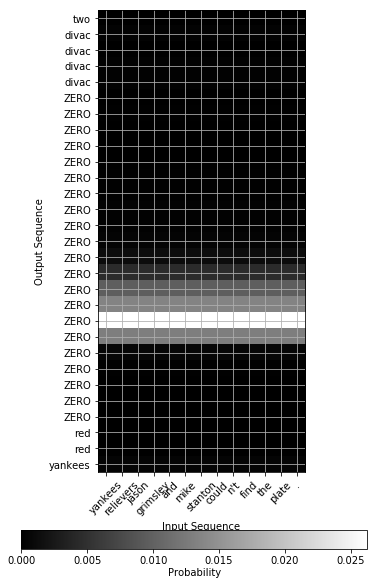

In [106]:
viz.attention_map(X_orig[15],padded_data_vector[15:16],y_ix_to_word)
print('Completed visualizations')

In [46]:
model = temp_model

In [ ]:
for k in range(0,5):
            # Shuffling the training data every epoch to avoid local minima
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]

            # Training 1000 sequences at a time
            for i in range(0, len(X), 200):
                if i + 200 >= len(X):
                    i_end = len(X)
                else:
                    i_end = i + 200
                y_sequences = process_data(y[i:i_end], max(X_max_len,y_max_len), y_word_to_ix)

                print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
                temp_model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=1, verbose=1, validation_split=0.2)
            temp_model.save_weights('extra_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 0th 0/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3090 - acc: 0.6790 - val_loss: 1.1342 - val_acc: 0.7202
[INFO] Training model: epoch 0th 200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2267 - acc: 0.6912 - val_loss: 1.4441 - val_acc: 0.6600
[INFO] Training model: epoch 0th 400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2163 - acc: 0.7069 - val_loss: 1.3168 - val_acc: 0.6752
[INFO] Training model: epoch 0th 600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2003 - acc: 0.7137 - val_loss: 1.2431 - val_acc: 0.6918
[INFO] Training model: epoch 0th 800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [===============

160/160 [==============================] - 4s - loss: 1.4087 - acc: 0.6748 - val_loss: 1.1496 - val_acc: 0.7394
[INFO] Training model: epoch 0th 7600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3129 - acc: 0.6812 - val_loss: 1.4274 - val_acc: 0.6532
[INFO] Training model: epoch 0th 7800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4214 - acc: 0.6631 - val_loss: 1.2242 - val_acc: 0.6866
[INFO] Training model: epoch 0th 8000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2475 - acc: 0.7021 - val_loss: 1.3979 - val_acc: 0.6725
[INFO] Training model: epoch 0th 8200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3945 - acc: 0.6693 - val_loss: 1.5463 - val_acc: 0.6417
[INFO] Train

160/160 [==============================] - 4s - loss: 1.3666 - acc: 0.6689 - val_loss: 1.3495 - val_acc: 0.6883
[INFO] Training model: epoch 0th 22400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3939 - acc: 0.6681 - val_loss: 1.2370 - val_acc: 0.6812
[INFO] Training model: epoch 0th 22600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4473 - acc: 0.6519 - val_loss: 1.1639 - val_acc: 0.7109
[INFO] Training model: epoch 0th 22800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3824 - acc: 0.6731 - val_loss: 1.5818 - val_acc: 0.6490
[INFO] Training model: epoch 0th 23000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3181 - acc: 0.6795 - val_loss: 1.1599 - val_acc: 0.7151
[INFO] T

160/160 [==============================] - 4s - loss: 1.3471 - acc: 0.6835 - val_loss: 1.0994 - val_acc: 0.7028
[INFO] Training model: epoch 0th 37200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4452 - acc: 0.6596 - val_loss: 1.4662 - val_acc: 0.6691
[INFO] Training model: epoch 0th 37400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4600 - acc: 0.6563 - val_loss: 1.2715 - val_acc: 0.6930
[INFO] Training model: epoch 0th 37600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3879 - acc: 0.6820 - val_loss: 1.2644 - val_acc: 0.6793
[INFO] Training model: epoch 0th 37800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3690 - acc: 0.6813 - val_loss: 1.2809 - val_acc: 0.6900
[INFO] T

160/160 [==============================] - 4s - loss: 1.3189 - acc: 0.6876 - val_loss: 1.4535 - val_acc: 0.6627
[INFO] Training model: epoch 1th 2800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1634 - acc: 0.7009 - val_loss: 1.3356 - val_acc: 0.7025
[INFO] Training model: epoch 1th 3000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.4053 - acc: 0.6755 - val_loss: 1.3873 - val_acc: 0.6461
[INFO] Training model: epoch 1th 3200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3092 - acc: 0.6912 - val_loss: 1.1694 - val_acc: 0.7214
[INFO] Training model: epoch 1th 3400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2398 - acc: 0.6906 - val_loss: 1.3036 - val_acc: 0.6819
[INFO] Train

160/160 [==============================] - 4s - loss: 1.2254 - acc: 0.6979 - val_loss: 1.5026 - val_acc: 0.6632
[INFO] Training model: epoch 1th 17600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2989 - acc: 0.6921 - val_loss: 1.3255 - val_acc: 0.6684
[INFO] Training model: epoch 1th 17800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2342 - acc: 0.7039 - val_loss: 1.3124 - val_acc: 0.6872
[INFO] Training model: epoch 1th 18000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2338 - acc: 0.7087 - val_loss: 1.1914 - val_acc: 0.7056
[INFO] Training model: epoch 1th 18200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2341 - acc: 0.6969 - val_loss: 1.1412 - val_acc: 0.7409
[INFO] T

160/160 [==============================] - 4s - loss: 1.2619 - acc: 0.6921 - val_loss: 1.4236 - val_acc: 0.6528
[INFO] Training model: epoch 1th 32400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3695 - acc: 0.6781 - val_loss: 1.2575 - val_acc: 0.7014
[INFO] Training model: epoch 1th 32600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3577 - acc: 0.6685 - val_loss: 1.2746 - val_acc: 0.6748
[INFO] Training model: epoch 1th 32800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2905 - acc: 0.6930 - val_loss: 1.1863 - val_acc: 0.7012
[INFO] Training model: epoch 1th 33000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2276 - acc: 0.7076 - val_loss: 1.4740 - val_acc: 0.6516
[INFO] T

160/160 [==============================] - 4s - loss: 1.1739 - acc: 0.7103 - val_loss: 1.3210 - val_acc: 0.6673
[INFO] Training model: epoch 1th 47200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3534 - acc: 0.6813 - val_loss: 1.3624 - val_acc: 0.6782
[INFO] Training model: epoch 1th 47400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3924 - acc: 0.6693 - val_loss: 1.3234 - val_acc: 0.6922
[INFO] Training model: epoch 1th 47600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2698 - acc: 0.6883 - val_loss: 1.4597 - val_acc: 0.6545
[INFO] Training model: epoch 1th 47800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3457 - acc: 0.6789 - val_loss: 1.2943 - val_acc: 0.6870
[INFO] T

160/160 [==============================] - 4s - loss: 1.2169 - acc: 0.7012 - val_loss: 1.0998 - val_acc: 0.7369
[INFO] Training model: epoch 2th 12000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1548 - acc: 0.7106 - val_loss: 0.9517 - val_acc: 0.7396
[INFO] Training model: epoch 2th 12200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1990 - acc: 0.7026 - val_loss: 1.3760 - val_acc: 0.6496
[INFO] Training model: epoch 2th 12400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2184 - acc: 0.7063 - val_loss: 1.3610 - val_acc: 0.6906
[INFO] Training model: epoch 2th 12600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2260 - acc: 0.7184 - val_loss: 1.0770 - val_acc: 0.7388
[INFO] T

160/160 [==============================] - 4s - loss: 1.2755 - acc: 0.6910 - val_loss: 0.9136 - val_acc: 0.7518
[INFO] Training model: epoch 2th 26800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2767 - acc: 0.6807 - val_loss: 1.0335 - val_acc: 0.7343
[INFO] Training model: epoch 2th 27000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1601 - acc: 0.7102 - val_loss: 1.1777 - val_acc: 0.7123
[INFO] Training model: epoch 2th 27200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2648 - acc: 0.6910 - val_loss: 1.2038 - val_acc: 0.7049
[INFO] Training model: epoch 2th 27400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2508 - acc: 0.6988 - val_loss: 1.4157 - val_acc: 0.6620
[INFO] T

160/160 [==============================] - 4s - loss: 1.2649 - acc: 0.6969 - val_loss: 1.0367 - val_acc: 0.7344
[INFO] Training model: epoch 2th 41600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1985 - acc: 0.7039 - val_loss: 1.2519 - val_acc: 0.7096
[INFO] Training model: epoch 2th 41800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3645 - acc: 0.6749 - val_loss: 1.2367 - val_acc: 0.6930
[INFO] Training model: epoch 2th 42000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2861 - acc: 0.6984 - val_loss: 1.4746 - val_acc: 0.6602
[INFO] Training model: epoch 2th 42200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3228 - acc: 0.6847 - val_loss: 1.2583 - val_acc: 0.7054
[INFO] T

160/160 [==============================] - 4s - loss: 1.1955 - acc: 0.7028 - val_loss: 1.1856 - val_acc: 0.7011
[INFO] Training model: epoch 3th 6400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.0876 - acc: 0.7160 - val_loss: 1.0168 - val_acc: 0.7576
[INFO] Training model: epoch 3th 6600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1252 - acc: 0.7206 - val_loss: 1.0182 - val_acc: 0.7390
[INFO] Training model: epoch 3th 6800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2592 - acc: 0.6873 - val_loss: 1.0945 - val_acc: 0.7179
[INFO] Training model: epoch 3th 7000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.0641 - acc: 0.7345 - val_loss: 1.1640 - val_acc: 0.6975
[INFO] Train

160/160 [==============================] - 4s - loss: 1.0715 - acc: 0.7348 - val_loss: 1.1521 - val_acc: 0.7188
[INFO] Training model: epoch 3th 21200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2364 - acc: 0.6952 - val_loss: 1.1467 - val_acc: 0.7089
[INFO] Training model: epoch 3th 21400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1540 - acc: 0.7079 - val_loss: 1.2063 - val_acc: 0.7225
[INFO] Training model: epoch 3th 21600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1300 - acc: 0.7209 - val_loss: 1.1236 - val_acc: 0.7185
[INFO] Training model: epoch 3th 21800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1177 - acc: 0.7254 - val_loss: 1.2535 - val_acc: 0.6932
[INFO] T

160/160 [==============================] - 4s - loss: 1.2374 - acc: 0.6959 - val_loss: 1.1706 - val_acc: 0.6929
[INFO] Training model: epoch 3th 36000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1676 - acc: 0.7125 - val_loss: 1.1573 - val_acc: 0.7245
[INFO] Training model: epoch 3th 36200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2461 - acc: 0.7045 - val_loss: 1.1612 - val_acc: 0.7263
[INFO] Training model: epoch 3th 36400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2302 - acc: 0.7015 - val_loss: 1.1644 - val_acc: 0.7231
[INFO] Training model: epoch 3th 36600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1633 - acc: 0.7154 - val_loss: 1.3517 - val_acc: 0.6617
[INFO] T

160/160 [==============================] - 4s - loss: 1.0808 - acc: 0.7272 - val_loss: 1.2249 - val_acc: 0.6882
[INFO] Training model: epoch 4th 800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1703 - acc: 0.7004 - val_loss: 1.1948 - val_acc: 0.7138
[INFO] Training model: epoch 4th 1000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1185 - acc: 0.7192 - val_loss: 1.0297 - val_acc: 0.7304
[INFO] Training model: epoch 4th 1200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1793 - acc: 0.7080 - val_loss: 1.1335 - val_acc: 0.7037
[INFO] Training model: epoch 4th 1400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.0424 - acc: 0.7343 - val_loss: 1.1668 - val_acc: 0.7096
[INFO] Traini

160/160 [==============================] - 4s - loss: 1.1972 - acc: 0.7143 - val_loss: 1.1246 - val_acc: 0.7140
[INFO] Training model: epoch 4th 15600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1556 - acc: 0.7061 - val_loss: 1.0023 - val_acc: 0.7330
[INFO] Training model: epoch 4th 15800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2162 - acc: 0.7030 - val_loss: 0.9556 - val_acc: 0.7607
[INFO] Training model: epoch 4th 16000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2060 - acc: 0.6944 - val_loss: 0.9017 - val_acc: 0.7596
[INFO] Training model: epoch 4th 16200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2157 - acc: 0.7068 - val_loss: 1.2579 - val_acc: 0.7102
[INFO] T

160/160 [==============================] - 4s - loss: 1.1545 - acc: 0.7021 - val_loss: 1.2353 - val_acc: 0.7166
[INFO] Training model: epoch 4th 30400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2592 - acc: 0.6798 - val_loss: 1.2321 - val_acc: 0.6937
[INFO] Training model: epoch 4th 30600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1341 - acc: 0.7156 - val_loss: 1.0756 - val_acc: 0.7270
[INFO] Training model: epoch 4th 30800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2830 - acc: 0.6917 - val_loss: 1.3559 - val_acc: 0.6885
[INFO] Training model: epoch 4th 31000/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.1067 - acc: 0.7304 - val_loss: 1.0963 - val_acc: 0.7284
[INFO] T

160/160 [==============================] - 4s - loss: 1.1832 - acc: 0.6981 - val_loss: 1.1394 - val_acc: 0.7120
[INFO] Training model: epoch 4th 45200/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2439 - acc: 0.6862 - val_loss: 1.2693 - val_acc: 0.7054
[INFO] Training model: epoch 4th 45400/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2028 - acc: 0.7008 - val_loss: 1.1758 - val_acc: 0.7184
[INFO] Training model: epoch 4th 45600/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.2218 - acc: 0.7055 - val_loss: 0.9793 - val_acc: 0.7654
[INFO] Training model: epoch 4th 45800/50000 samples
Train on 160 samples, validate on 40 samples
Epoch 1/1
160/160 [==============================] - 4s - loss: 1.3101 - acc: 0.6837 - val_loss: 1.0442 - val_acc: 0.7294
[INFO] T

In [57]:
predictions = np.argmax(temp_model.predict(X_test[0:7000]), axis=2)

In [62]:
sequences = []
for prediction in predictions:
    valids = [y_ix_to_word[index] for index in prediction if index > 0 and y_ix_to_word[index]!='divac']
    sequence = ' '.join(valids)
    sequences.append(sequence)

In [44]:
get_rouge_score(sequences, y_test[0:7000]) 

{'rouge-1': {'f': 0.15467639146051917,
  'p': 0.1703763450834879,
  'r': 0.15085931682389556},
 'rouge-2': {'f': 0.035568509295693863,
  'p': 0.02991372318158032,
  'r': 0.046192173897531039},
 'rouge-l': {'f': 0.083447808909232576,
  'p': 0.076045095202607896,
  'r': 0.14639337338358235}}

In [152]:
for i in range(4600,4800):
    print('Summary: ' + sequences[i])
    print('Original: ' + X_orig[i])
    print('Original Summary: ' + y_orig[i])
    print('\n')

Summary: end at at brazil at in at world cup draws
Original: the seventh international science and peace week in china opened here today .
Original Summary: science and peace week opens in beijing


Summary: auction south south africa coalition coalition to to president president
Original: the australian stock exchange rose slightly despite weaker overseas markets .
Original Summary: australian stock exchange rises


Summary: top UNK UNK UNK tour tour tour ireland ireland tour tour the tour
Original: belgian tennis star kim clijsters has reiterated her plan to retire in #### .
Original Summary: clijsters confirms retirement in ####


Summary: els els els els els els els for for for the straight loss
Original: u.s. stocks opened lower on monday , as oil prices hovered below ## dollars .
Original Summary: u.s. stocks open lower


Summary: super makes makes with with most too
Original: tokyo stocks opened lower friday as exporters lost ground on a stronger yen .
Original Summary: tokyo st

In [118]:
X_test, y_test, X_orig, y_orig = load_test_data('data/train_article.txt','data/train_title.txt', X_word_to_ix, 200)

In [121]:
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32')
padded_data_vector = pad_sequences(X_test, maxlen=max(X_max_len,y_max_len), dtype='int32')

In [148]:
viz = Visualizer()